<a href="https://colab.research.google.com/github/Rana-AlMaaz/AI_Program_Project_Repository/blob/main/Chest_X_Ray_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the training, validation, and test datasets

In [ ]:
import tensorflow as tf

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/chest_xray_data/chest_xray/train',         # path to main folder
    labels='inferred',      # infers label from subfolder names
    image_size=(150,150),
    label_mode='int'
)

Found 5216 files belonging to 2 classes.


In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/chest_xray_data/chest_xray/test',         # path to main folder
    labels='inferred',         # infers label from subfolder names
    image_size=(150,150),
    label_mode='int'
)

Found 624 files belonging to 2 classes.


In [ ]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/chest_xray_data/chest_xray/val',         # path to main folder
    labels='inferred',         # infers label from subfolder names
    image_size=(150,150),
    label_mode='int'
)

Found 16 files belonging to 2 classes.


###Visualize a sample of the images of training dataset

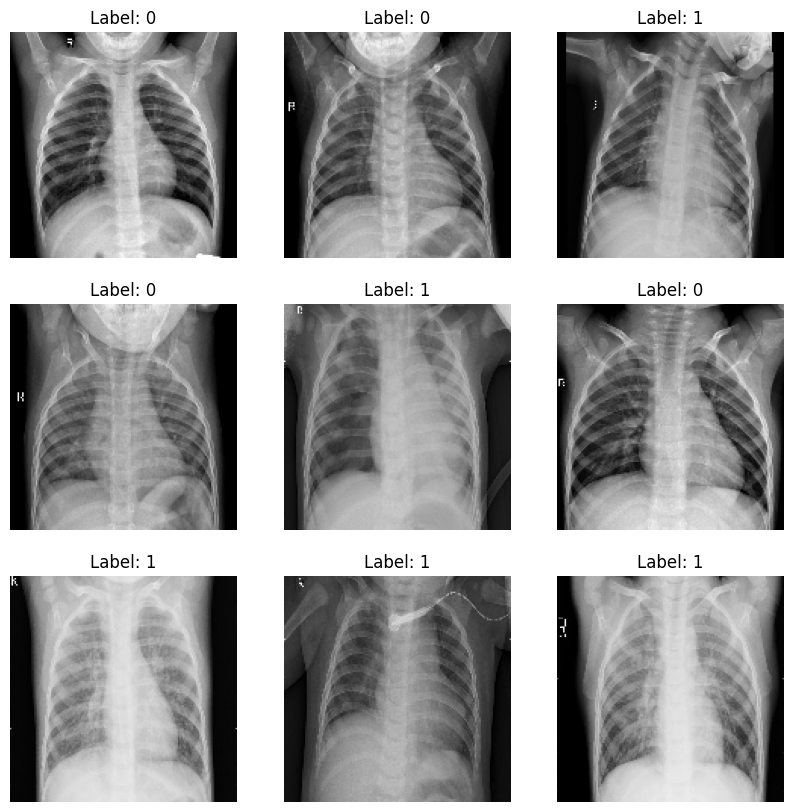

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")

###Check for properties of images

In [ ]:
# Take one batch from the dataset
for images, labels in train_dataset.take(1):
    print("Batch shape:", images.shape)     # (batch_size, height, width, channels)
    print("Data type:", images.dtype)        # usually tf.float32 or tf.uint8

    # Inspect the first image in the batch
    img = images[0]
    label = labels[0]

    print("Single image shape:", img.shape)  # (height, width, channels)
    print("Single label:", label.numpy())
    print("Pixel values range (min, max):", tf.reduce_min(img).numpy(), tf.reduce_max(img).numpy())
    break

Batch shape: (32, 150, 150, 3)
Data type: <dtype: 'float32'>
Single image shape: (150, 150, 3)
Single label: 1
Pixel values range (min, max): 0.0 254.97853


###Let's check whether the dataset is balanced or not

In [ ]:
# Initialize empty list to collect all labels
all_labels = []

# Loop through the dataset and collect labels
for _, labels in train_dataset:
    all_labels.extend(labels.numpy())  # Convert tensor to numpy and extend the list

# Use NumPy to count occurrences
classes, counts = np.unique(all_labels, return_counts=True)

# Print class distribution
for cls, count in zip(classes, counts):
    print(f"Class {cls}: {count} images")


Class 0: 1341 images
Class 1: 3875 images


###As shown above, the number of images of class 0 (which refers to the normal images) is much less than that of the pneumonia. So, we augment the normal part of the dataset to icrease the number of the normal images.

In [ ]:
# 1. Unbatch the dataset so we can filter individual examples
unbatched_ds = train_dataset.unbatch()

In [ ]:
normal_ds = unbatched_ds.filter(lambda x, y: tf.equal(y, 0))
pneumonia_ds = unbatched_ds.filter(lambda x, y: tf.equal(y, 1))

In [ ]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

augmented_normal_ds = normal_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
combined_ds = normal_ds.concatenate(augmented_normal_ds).concatenate(pneumonia_ds)
balanced_ds = combined_ds.shuffle(1000).batch(32)

In [ ]:
rescale = layers.Rescaling(1./255)

balanced_ds = balanced_ds.map(lambda x, y: (rescale(x), y))
val_dataset = val_dataset.map(lambda x, y: (rescale(x), y))

In [ ]:
# Initialize empty list to collect all labels
all_labels = []

# Loop through the dataset and collect labels
for _, labels in balanced_ds:
    all_labels.extend(labels.numpy())  # Convert tensor to numpy and extend the list

# Use NumPy to count occurrences
classes, counts = np.unique(all_labels, return_counts=True)

# Print class distribution
for cls, count in zip(classes, counts):
    print(f"Class {cls}: {count} images")


Class 0: 2682 images
Class 1: 3875 images


###As shown above, the dataset is now fair. Now, let's build the CNN model

In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation="sigmoid"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73984)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,735,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,791,425 (18.28 MB)

 Trainable params: 4,791,425 (18.28 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(balanced_ds, epochs=10,
                    validation_data=(val_dataset))

Epoch 1/10
    205/Unknown 100s 355ms/step - accuracy: 0.9267 - loss: 0.3971

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


205/205 ━━━━━━━━━━━━━━━━━━━━ 101s 360ms/step - accuracy: 0.9267 - loss: 0.3968 - val_accuracy: 0.5625 - val_loss: 2.5012
Epoch 2/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 136s 355ms/step - accuracy: 0.9101 - loss: 0.4559 - val_accuracy: 0.5000 - val_loss: 1.7664
Epoch 3/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 92s 347ms/step - accuracy: 0.9136 - loss: 0.5362 - val_accuracy: 0.5000 - val_loss: 2.4985
Epoch 4/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 142s 354ms/step - accuracy: 0.8898 - loss: 0.4084 - val_accuracy: 0.5000 - val_loss: 1.0791
Epoch 5/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 93s 348ms/step - accuracy: 0.9361 - loss: 1.0781 - val_accuracy: 0.5000 - val_loss: 2.3415
Epoch 6/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 142s 350ms/step - accuracy: 0.9111 - loss: 0.3904 - val_accuracy: 0.5625 - val_loss: 0.7633
Epoch 7/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 141s 354ms/step - accuracy: 0.9328 - loss: 0.2423 - val_accuracy: 0.6250 - val_loss: 1.4453
Epoch 8/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 142s 353ms/step - accuracy: 0.8752 - loss: 0.3783

In [ ]:
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype("int32").flatten())  # convert to 0 or 1


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

              precision    recall  f1-score   support

      NORMAL       0.77      0.52      0.62       234
   PNEUMONIA       0.76      0.91      0.83       390

    accuracy                           0.76       624
   macro avg       0.76      0.71      0.72       624
weighted avg       0.76      0.76      0.75       624



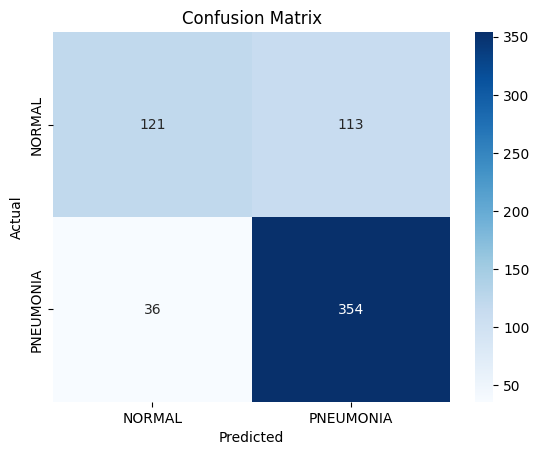

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NORMAL", "PNEUMONIA"],
            yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

As shown in the confusion matrix above, the model is pretty good in detecting pneumonia, and this is what we want.

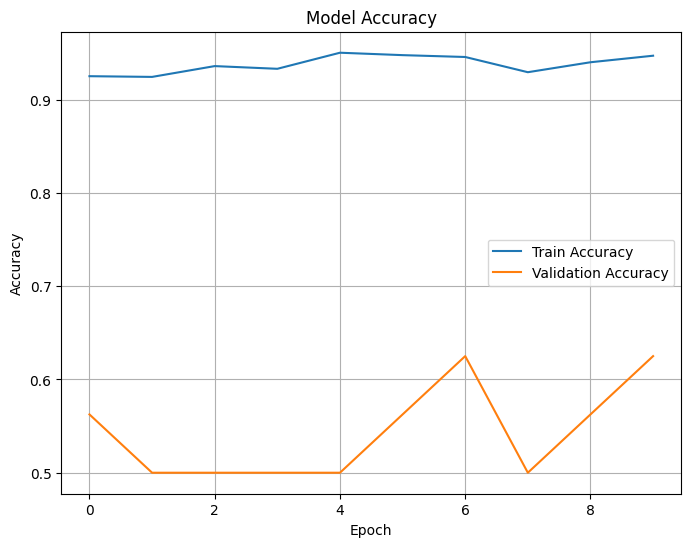

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

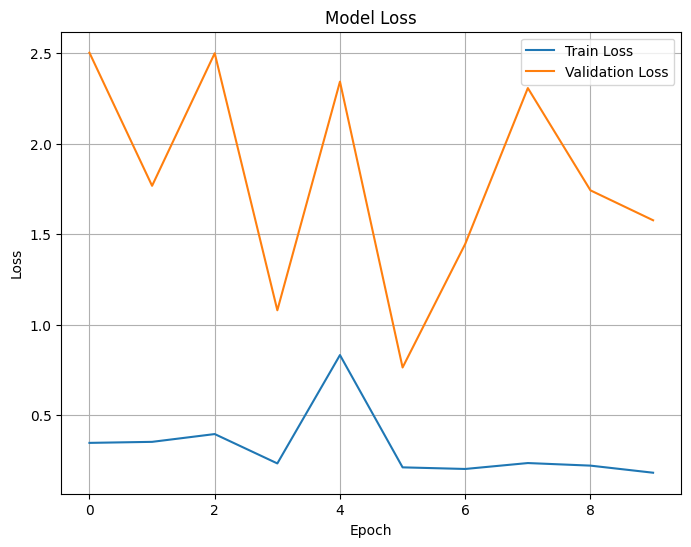

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

The above two graphs indicate overfitting of the model.